## Домашняя работа

Будем работать с датасетом подержанных машин https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes.

Задача - построить прогноз цены машины по ее данным (год выпуска, пробег, расход, размер двигателя, тип коробки передач и тд).

Это задача регрессии, поэтому нужно использовать модели регрессоры, а не классификаторы (например, не StackingClassifier, а StackingRegressor).

# Easy

Взять один файл с маркой машины.
Построить прогноз, используя модели линейной регрессии и случайного леса. Сравнить результаты, используя кросс-валидацию. Подобрать гиперпараметры моделей (для линейной регрессии можно использовать реализацию с градиентным спуском SGDRegressor). Оценить качество, используя метрику r2_score. Оценить важность признаков (параметр feature_importance_ у случайного леса).

In [254]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('C:\\Users\\UserOfPC\\Downloads\\brunoyam\\data\\vw.csv', sep=',', quoting=3, engine='python')
data

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,T-Roc,2019,25000,Automatic,13904,Diesel,145,49.6,2.0
1,T-Roc,2019,26883,Automatic,4562,Diesel,145,49.6,2.0
2,T-Roc,2019,20000,Manual,7414,Diesel,145,50.4,2.0
3,T-Roc,2019,33492,Automatic,4825,Petrol,145,32.5,2.0
4,T-Roc,2019,22900,Semi-Auto,6500,Petrol,150,39.8,1.5
...,...,...,...,...,...,...,...,...,...
15152,Eos,2012,5990,Manual,74000,Diesel,125,58.9,2.0
15153,Fox,2008,1799,Manual,88102,Petrol,145,46.3,1.2
15154,Fox,2009,1590,Manual,70000,Petrol,200,42.0,1.4
15155,Fox,2006,1250,Manual,82704,Petrol,150,46.3,1.2


Сделаем глубокую копию нашего датасета, работать будем с датасетом data

In [3]:
data_clean = data.copy(deep = True)

In [4]:
data.info

<bound method DataFrame.info of         model  year  price transmission  mileage fuelType  tax   mpg  \
0       T-Roc  2019  25000    Automatic    13904   Diesel  145  49.6   
1       T-Roc  2019  26883    Automatic     4562   Diesel  145  49.6   
2       T-Roc  2019  20000       Manual     7414   Diesel  145  50.4   
3       T-Roc  2019  33492    Automatic     4825   Petrol  145  32.5   
4       T-Roc  2019  22900    Semi-Auto     6500   Petrol  150  39.8   
...       ...   ...    ...          ...      ...      ...  ...   ...   
15152     Eos  2012   5990       Manual    74000   Diesel  125  58.9   
15153     Fox  2008   1799       Manual    88102   Petrol  145  46.3   
15154     Fox  2009   1590       Manual    70000   Petrol  200  42.0   
15155     Fox  2006   1250       Manual    82704   Petrol  150  46.3   
15156     Fox  2007   2295       Manual    74000   Petrol  145  46.3   

       engineSize  
0             2.0  
1             2.0  
2             2.0  
3             2.0  
4  

In [5]:
data.groupby(['model'])['price'].count()

model
 Amarok              111
 Arteon              248
 Beetle               83
 CC                   95
 Caddy                 6
 Caddy Life            8
 Caddy Maxi            4
 Caddy Maxi Life      59
 California           15
 Caravelle           101
 Eos                   7
 Fox                   4
 Golf               4863
 Golf SV             268
 Jetta                32
 Passat              915
 Polo               3287
 Scirocco            242
 Sharan              260
 Shuttle              61
 T-Cross             300
 T-Roc               733
 Tiguan             1765
 Tiguan Allspace      91
 Touareg             363
 Touran              352
 Up                  884
Name: price, dtype: int64

Всего 27 групп - моделей марки VW

In [6]:
data.isna().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

NaN значений в таблице - нет

Посмотрим на коррелицию признаков на тепловой карте

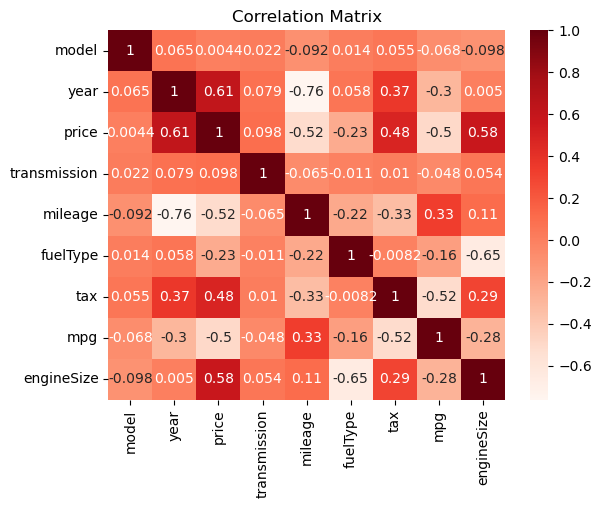

In [255]:
sns.heatmap(data.corr(), cmap ="Reds", annot = True)
plt.title("Correlation Matrix")
plt.show()

Видно, что существует высокая положительная корреляция между ценой и годом выпуска, а также между ценой и размером двигателя. Это значит что, чем новее год, тем выше цена, а также чем больше объем двигателя, тем также выше цена авто.

Однако, есть и отрицательная корреляция - между ценой и пробегом, например. Это означает, что чем больше пробег у авто, тем сильнее это снижает цену.

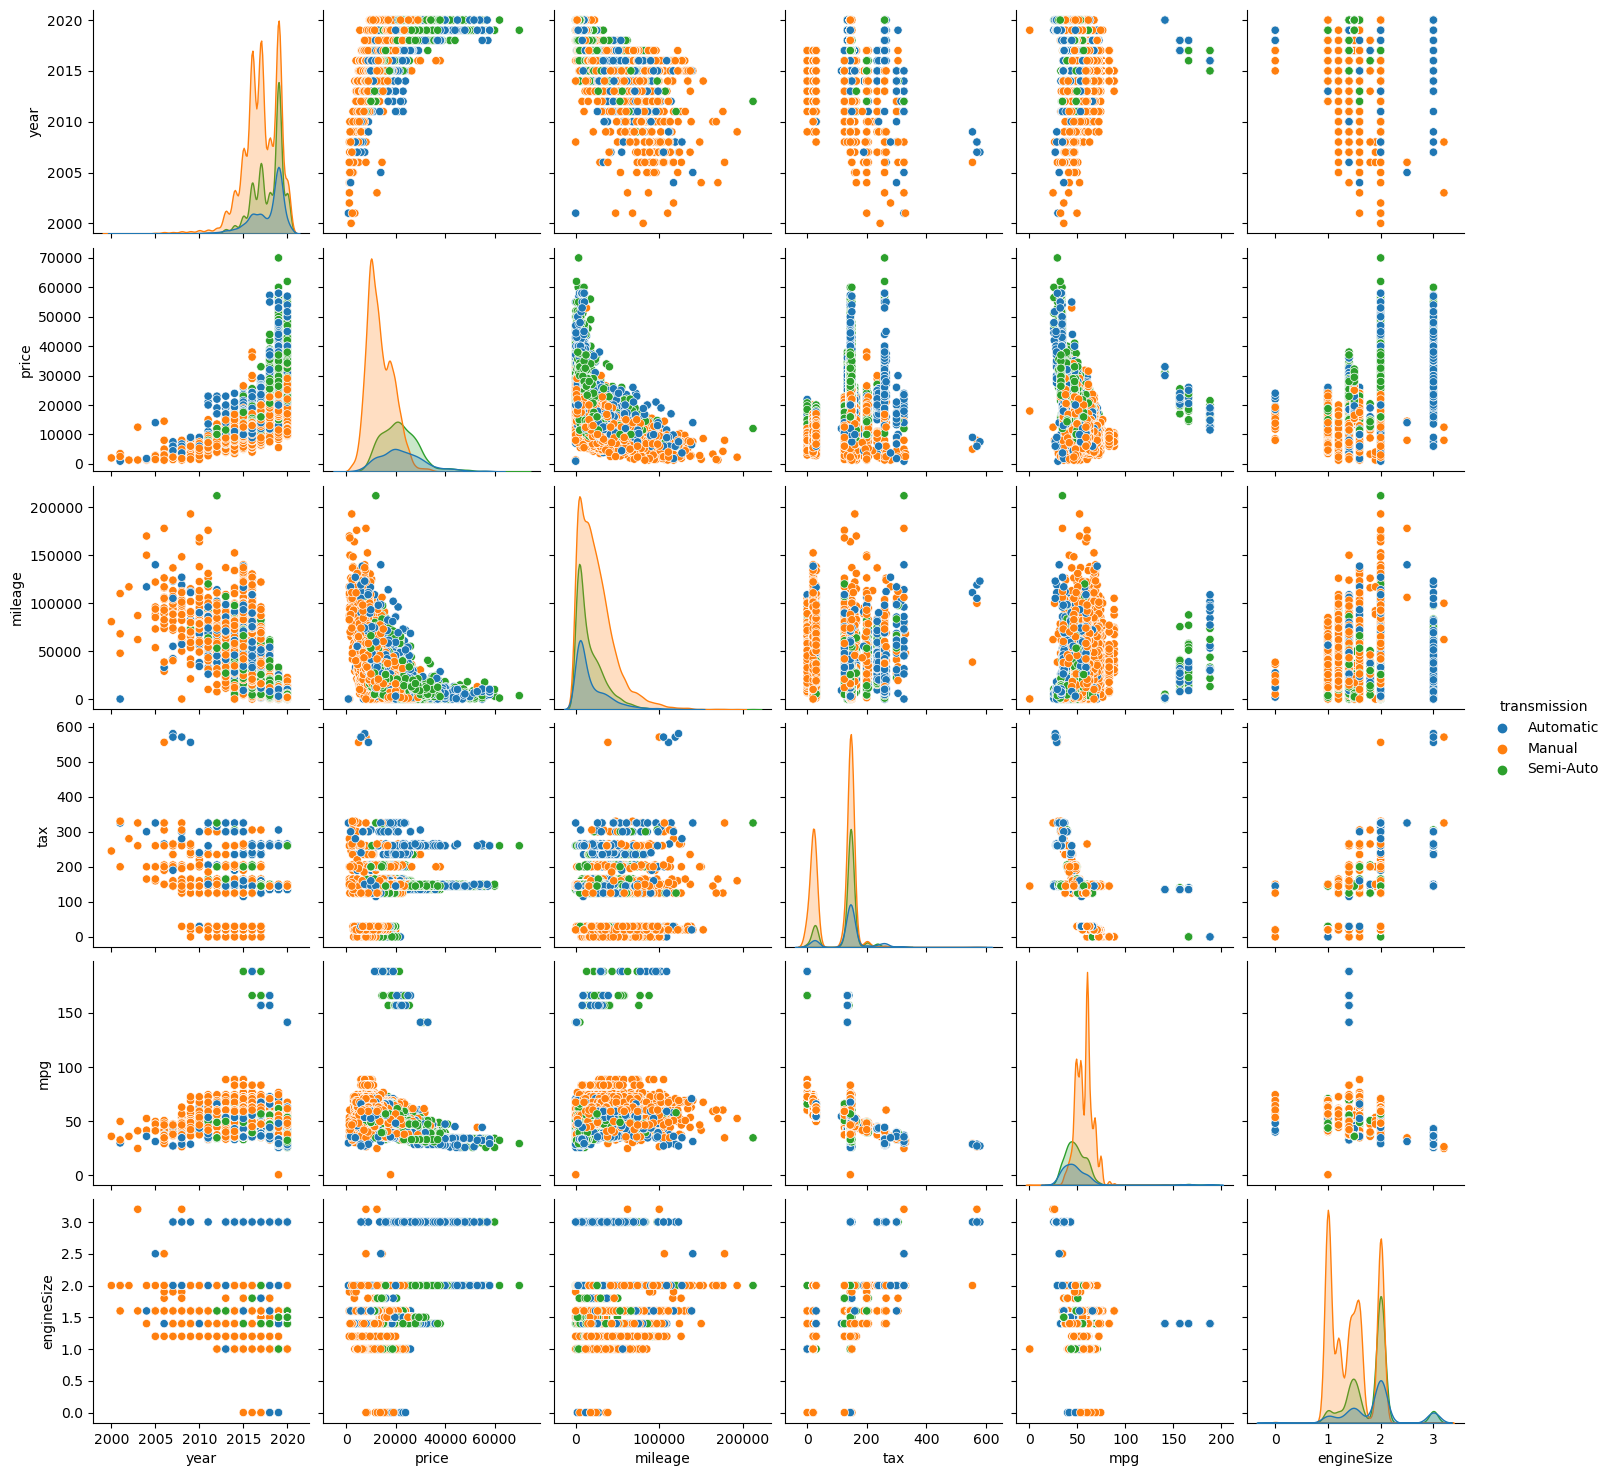

In [8]:
sns.pairplot(data, hue='transmission')

Из графиков видим некоторые зависимости признаков от типа коробки передач:
    
    1. В более старых авто преобладают механические К.П., цена на такие авто гораздо ниже остальных.
    
    2. В авто с 2012 г. стали встречаться К.П. полу-автоматические. Цена на такие авто выше чем на авто с механикой.
    
    3. В современных авто цена на автомобили с автоматической и полу-автоматической К.П. гораздо выше, чем с механикой.

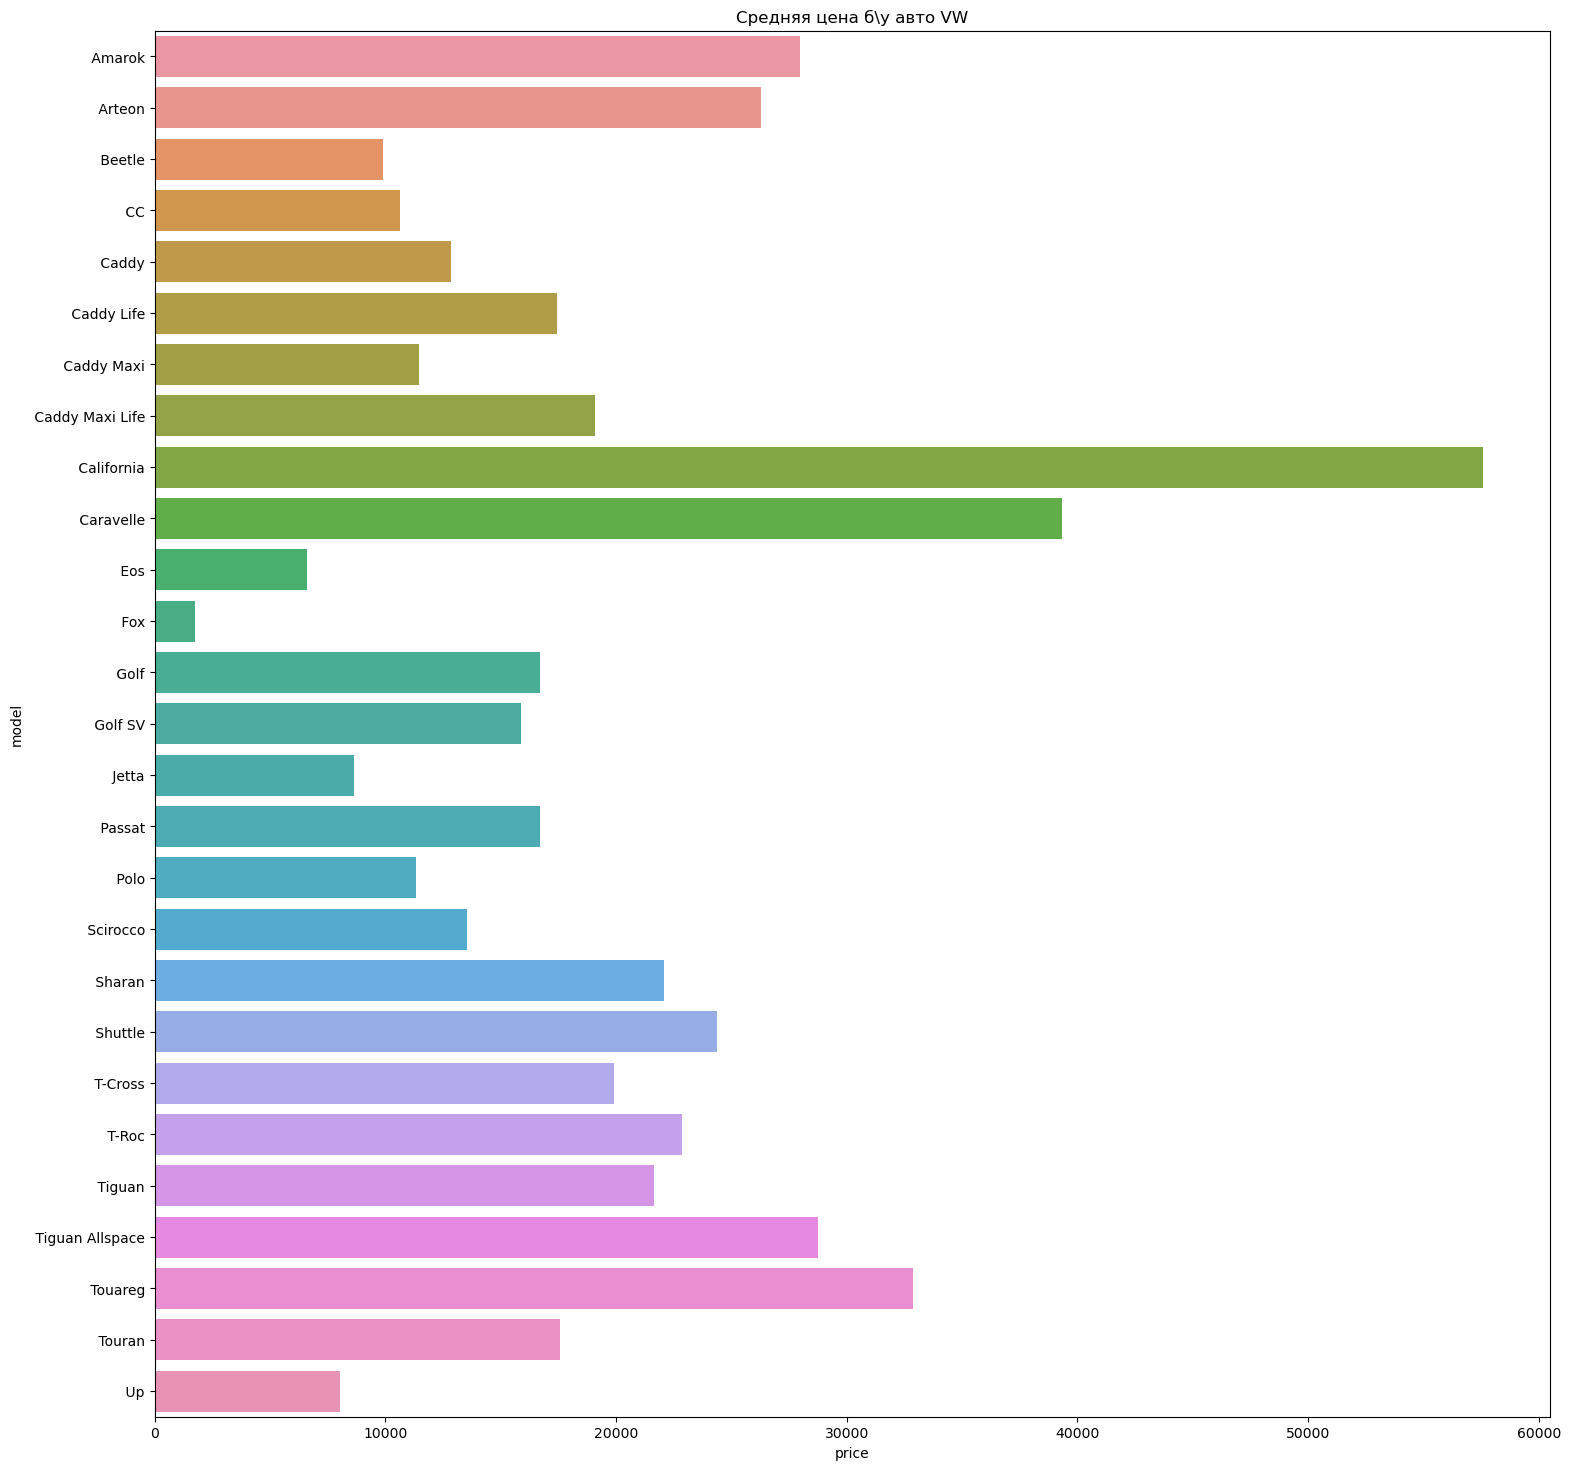

In [9]:
plt.subplots(figsize = (18,18))
data_price_Model = data.groupby("model")['price'].mean().reset_index()
sns.barplot(x = 'price', y = 'model', data = data_price_Model)
plt.title("Средняя цена б\у авто VW")
plt.show()

С большим отрывом по цене - Volkswagen California — это многофункциональный минивэн, с полностью оборудованной кухней и подъемной крышей.

Посмотрим на графиках на попарную зависимость всех признаков

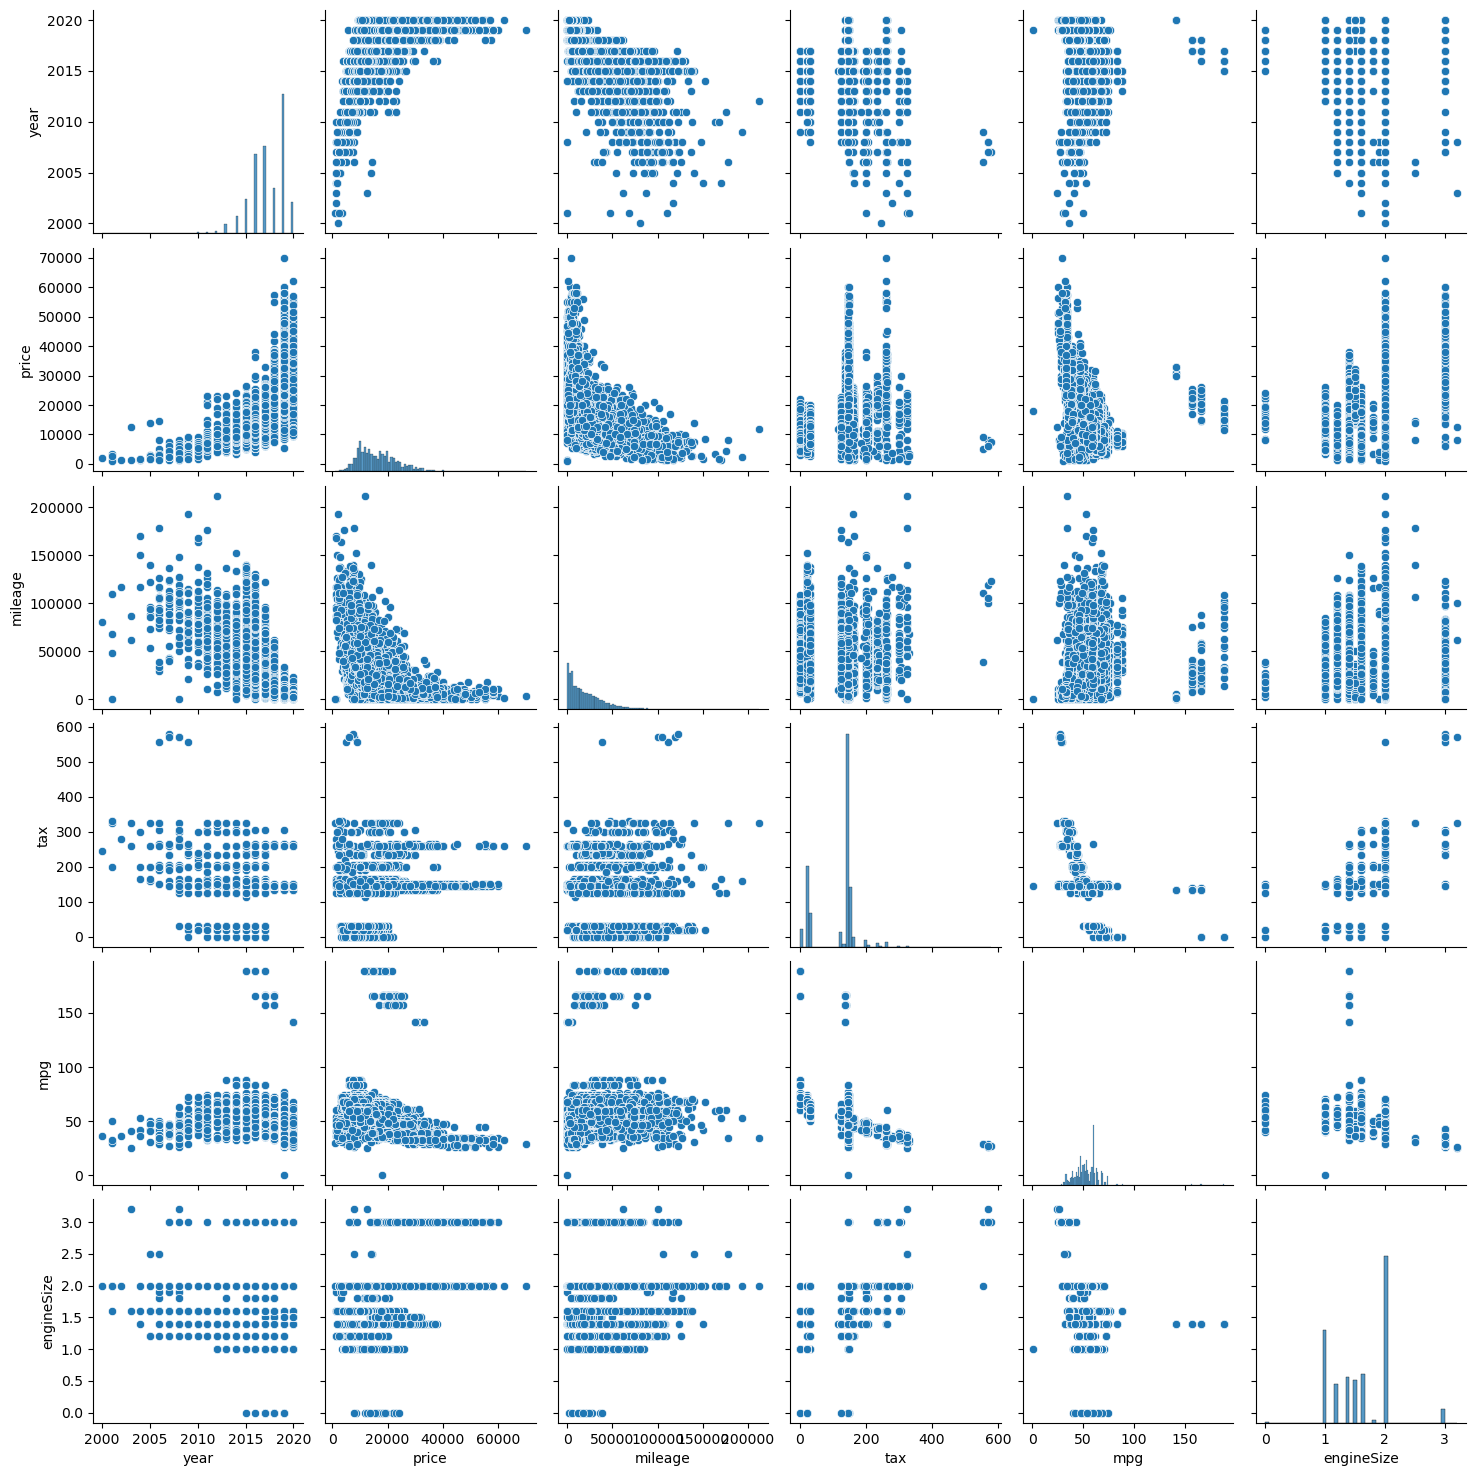

In [10]:
sns.pairplot(data)

Закодируем текстовые данные, а затем нормализуем все данные.

In [11]:
encoder = LabelEncoder()
data['model'] = encoder.fit_transform(data['model'])
model_cat = {index : label for index, label in enumerate(encoder.classes_)}
model_cat

{0: ' Amarok',
 1: ' Arteon',
 2: ' Beetle',
 3: ' CC',
 4: ' Caddy',
 5: ' Caddy Life',
 6: ' Caddy Maxi',
 7: ' Caddy Maxi Life',
 8: ' California',
 9: ' Caravelle',
 10: ' Eos',
 11: ' Fox',
 12: ' Golf',
 13: ' Golf SV',
 14: ' Jetta',
 15: ' Passat',
 16: ' Polo',
 17: ' Scirocco',
 18: ' Sharan',
 19: ' Shuttle',
 20: ' T-Cross',
 21: ' T-Roc',
 22: ' Tiguan',
 23: ' Tiguan Allspace',
 24: ' Touareg',
 25: ' Touran',
 26: ' Up'}

In [12]:
data['transmission'] = encoder.fit_transform(data['transmission'])
transmission_cat= {index : label for index, label in enumerate(encoder.classes_)}
transmission_cat

{0: 'Automatic', 1: 'Manual', 2: 'Semi-Auto'}

In [13]:
data['fuelType'] = encoder.fit_transform(data['fuelType'])
fuelType_cat= {index : label for index, label in enumerate(encoder.classes_)}
fuelType_cat

{0: 'Diesel', 1: 'Hybrid', 2: 'Other', 3: 'Petrol'}

In [14]:
data.isnull().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

In [15]:
X = data.drop('price', axis = 1)
X = (X - X.mean()) / X.std()
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize
0,0.909065,0.849567,-1.855722,-0.387196,-1.162482,0.508103,-0.304449,0.864873
1,0.909065,0.849567,-1.855722,-0.828920,-1.162482,0.508103,-0.304449,0.864873
2,0.909065,0.849567,-0.198941,-0.694067,-1.162482,0.508103,-0.245808,0.864873
3,0.909065,0.849567,-1.855722,-0.816485,0.872286,0.508103,-1.557915,0.864873
4,0.909065,0.849567,1.457841,-0.737284,0.872286,0.586865,-1.022810,-0.218094
...,...,...,...,...,...,...,...,...
15152,-1.123083,-2.559980,-0.198941,2.454365,-1.162482,0.193056,0.377260,0.864873
15153,-0.938342,-4.508292,-0.198941,3.121159,0.872286,0.508103,-0.546346,-0.867874
15154,-0.938342,-4.021214,-0.198941,2.265230,0.872286,1.374482,-0.861545,-0.434687
15155,-0.938342,-5.482449,-0.198941,2.865922,0.872286,0.586865,-0.546346,-0.867874


In [16]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [17]:
y_pred = model.predict(X_test)

y_pred

array([14308.51104165,  6970.82249721, 10147.05749069, ...,
        4021.2998235 , 23820.52333193, 15069.81600938])

In [18]:
mean_squared_error(y_test, y_pred)

14088949.219403358

R2 вычислим (коэффициент детерминации) функция оценки регрессии.

In [20]:
r2 = r2_score(y_pred, y_test)
r2

0.6898478502941527

Коэффициент детерминации для модели с константой принимает значения от 0 до 1. Чем ближе значение коэффициента к 1, тем сильнее зависимость. При оценке регрессионных моделей это интерпретируется как соответствие модели данным. Для приемлемых моделей предполагается, что коэффициент детерминации должен быть хотя бы не меньше 50 % (в этом случае коэффициент множественной корреляции превышает по модулю 70 %). Модели с коэффициентом детерминации выше 80 % можно признать достаточно хорошими (коэффициент корреляции превышает 90 %). Значение коэффициента детерминации 1 означает функциональную зависимость между переменными.

В нашей моделе Линейной регресии коэффициент детерминации равен 69%, что не является удовлетворительным показателем, поэтому далее попробуем использовать другие модели Регрессии, а также реализуем подбор гиперпараметров на моделе Случайного леса.

In [106]:
model2 = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.3)

In [107]:
model2.fit(X_train, y_train)

SGDRegressor(eta0=0.3, penalty=None)

In [108]:
y_pred2 = model2.predict(X_test)
y_pred2

array([12102.87753447,  5150.78284771,  8859.03734971, ...,
        2635.44436288, 24573.50541406, 14712.17575159])

In [109]:
r2_2 = r2_score(y_pred2, y_test)
r2_2

0.7338898841565554

#RandomForestRegressor

In [25]:
model3 = RandomForestRegressor()
model3.fit(X_train, y_train)

y_pred3 = model3.predict(X_test)

In [26]:
r2_3 = r2_score(y_pred3, y_test)
r2_3

0.9585034835981417

Видим, что модель Случайного леса уже дала нам очень хороший результат. Посмотрим, получится ли его улучшить засчет удаления наименее важных признаков, а аткже подбора гиперпараметров.

In [54]:
feature_imp = pd.Series(model3.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

mpg             0.570263
year            0.170657
engineSize      0.109861
mileage         0.055552
model           0.046886
fuelType        0.027901
tax             0.013927
transmission    0.004953
dtype: float64

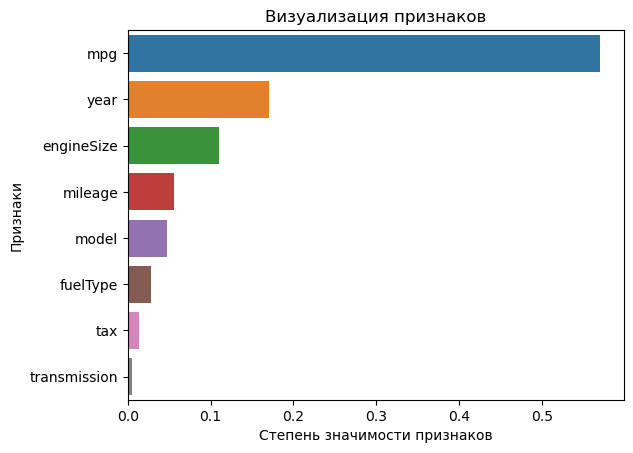

In [110]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Степень значимости признаков')
plt.ylabel('Признаки')
plt.title('Визуализация признаков')
plt.show()

Переобучим нашу модель случайного леса только на наиболее значимых признаках, отбросив "шум".

In [82]:
X1 = X.drop('transmission', axis = 1)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, train_size=0.8)

In [81]:
model4 = RandomForestRegressor()
model4 .fit(X_train1, y_train1)

y_pred4 = model4.predict(X_test1)

r2_4 = r2_score(y_pred4, y_test1)
r2_4

0.9506212658764222

Видим, что наиболее весомые признаки, влияющие на цену - расход топлива и год. После удаления наименее важного показателя (трансмиссия) коэффициент детерминации не сильно изменился, поэтому можем сказать, что наименее важные признаки не сильно влияют на точность прогноза модели.

Теперь попробуем улучшить производительность модели с помощью подборов гиперпараметров.

In [124]:
param_grid = [
    {"n_estimators": [10, 30, 40], "max_features": [2, 4, 6, 8]}]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [10, 30, 40]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [125]:
grid_search.best_params_

{'max_features': 4, 'n_estimators': 40}

In [126]:
model4 = RandomForestRegressor(max_features= 4, n_estimators = 40)
model4 .fit(X_train, y_train)

RandomForestRegressor(max_features=4, n_estimators=40)

In [127]:
y_pred4 = model4.predict(X_test)
r2_4 = r2_score(y_pred4, y_test)
r2_4

0.9583757539027761

Видим, что ни удаление наименее важных признаков из обучающей выборки, ни подбор гиперпараметров не оказали должного влияния на производительность модели RandomForestRegressor. Однако, модель и так показала хороший результат, т.к. коэффициент детерминации равен 96%. Это значит, что разница между выборками в наборе данных и прогнозами, сделанными моделью, минимальна. Модель обладает достаточной точностью прогноза цены.

#Normal

Объединить в один датафрейм данные по всем маркам машин. Преобразовать категориальные признаки.

Построить еще несколько моделей, используя подбор гиперпараметров. Сравнить между собой все построенные модели.

In [183]:
audi = pd.read_csv('C:\\Users\\UserOfPC\\Downloads\\brunoyam\\data\\авто\\audi.csv', sep=',', quoting=3, engine='python')

In [184]:
bmw = pd.read_csv('C:\\Users\\UserOfPC\\Downloads\\brunoyam\\data\\авто\\bmw.csv', sep=',', quoting=3, engine='python')

In [185]:
ford = pd.read_csv('C:\\Users\\UserOfPC\\Downloads\\brunoyam\\data\\авто\\ford.csv', sep=',', quoting=3, engine='python')

In [186]:
hyundi = pd.read_csv('C:\\Users\\UserOfPC\\Downloads\\brunoyam\\data\\авто\\hyundi.csv', sep=',', quoting=3, engine='python')

In [187]:
merc = pd.read_csv('C:\\Users\\UserOfPC\\Downloads\\brunoyam\\data\\авто\\merc.csv', sep=',', quoting=3, engine='python')

In [188]:
skoda = pd.read_csv('C:\\Users\\UserOfPC\\Downloads\\brunoyam\\data\\авто\\skoda.csv', sep=',', quoting=3, engine='python')

In [189]:
toyota = pd.read_csv('C:\\Users\\UserOfPC\\Downloads\\brunoyam\\data\\авто\\toyota.csv', sep=',', quoting=3, engine='python')

In [190]:
vw = pd.read_csv('C:\\Users\\UserOfPC\\Downloads\\brunoyam\\data\\авто\\vw.csv', sep=',', quoting=3, engine='python')

In [191]:
all_data = pd.concat([audi, bmw, ford, hyundi, merc, skoda, toyota, vw], ignore_index = True)
all_data = all_data.drop('tax(£)', axis = 1)
all_data

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0
...,...,...,...,...,...,...,...,...,...
85550,Eos,2012,5990,Manual,74000,Diesel,125.0,58.9,2.0
85551,Fox,2008,1799,Manual,88102,Petrol,145.0,46.3,1.2
85552,Fox,2009,1590,Manual,70000,Petrol,200.0,42.0,1.4
85553,Fox,2006,1250,Manual,82704,Petrol,150.0,46.3,1.2


In [192]:
encoder = LabelEncoder()
all_data['model'] = encoder.fit_transform(all_data['model'])
model_cat = {index : label for index, label in enumerate(encoder.classes_)}

In [193]:
all_data['transmission'] = encoder.fit_transform(all_data['transmission'])
model_cat = {index : label for index, label in enumerate(encoder.classes_)}

In [194]:
all_data['fuelType'] = encoder.fit_transform(all_data['fuelType'])
model_cat = {index : label for index, label in enumerate(encoder.classes_)}

In [195]:
all_data.isnull().sum()

model              0
year               0
price              0
transmission       0
mileage            0
fuelType           0
tax             4860
mpg                0
engineSize         0
dtype: int64

In [196]:
all_data = all_data.dropna(subset=['tax'])
all_data.isnull().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

In [197]:
X = all_data.drop('price', axis = 1)
X = (X - X.mean()) / X.std()
y = all_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)


In [198]:
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable


In [143]:
from catboost import CatBoostRegressor
catModel = CatBoostRegressor(verbose = 0, random_state = 33)
catModel.fit(X_train, y_train)
y_pred = catModel.predict(X_test)
r2 = r2_score(y_pred, y_test)
r2

0.9506539156609349

In [144]:
parameters = {'max_depth' : [2, 5, 10],
              'learning_rate' : [0.001, 0.01, 0.1],
              'n_estimators' : [100, 200],
              'min_child_samples' : [2, 5, 10]
             }

Rgrid_search = RandomizedSearchCV(catModel, parameters, scoring = 'r2', verbose = False)

Rgrid_search.fit(X_train, y_train)


RandomizedSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x000001E7B4CB8CD0>,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': [2, 5, 10],
                                        'min_child_samples': [2, 5, 10],
                                        'n_estimators': [100, 200]},
                   scoring='r2', verbose=False)

In [145]:
Rgrid_search.best_params_

{'n_estimators': 100,
 'min_child_samples': 5,
 'max_depth': 10,
 'learning_rate': 0.1}

In [146]:
catModel = CatBoostRegressor(verbose = 0, random_state = 33, n_estimators=100, min_child_samples = 5, max_depth=10, learning_rate=0.1)
catModel.fit(X_train, y_train)
y_pred = catModel.predict(X_test)
r2 = r2_score(y_pred, y_test)
r2

0.925500203786757

Посмотрим на выбросы в данных.

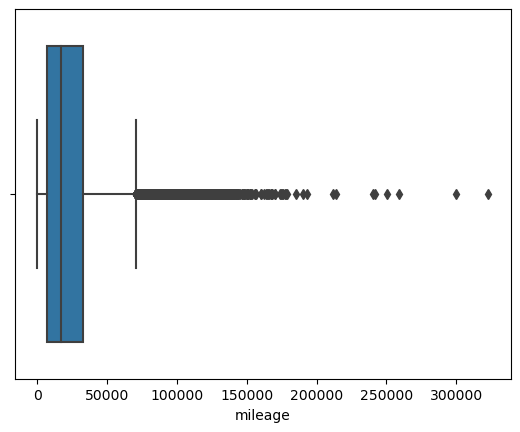

In [199]:
box1 = sns.boxplot(x = 'mileage', data = all_data)


In [201]:
all_data = all_data[all_data['mileage'] < 200000]

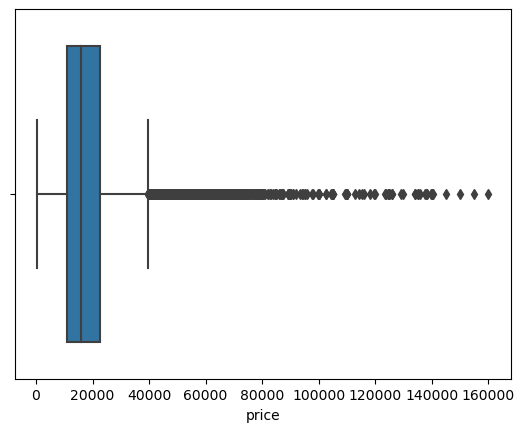

In [202]:
box1 = sns.boxplot(x = 'price', data = all_data)

In [203]:
all_data = all_data[all_data['price'] < 145000]

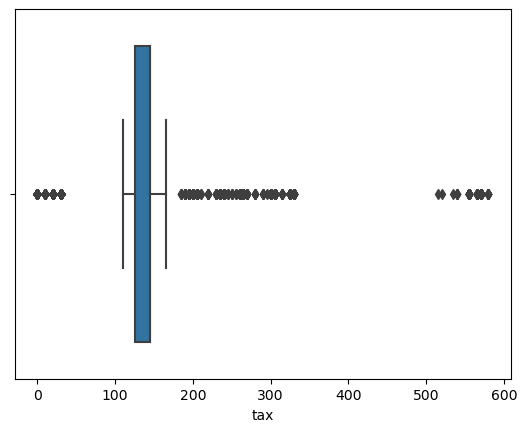

In [204]:
box1 = sns.boxplot(x = 'tax', data = all_data)

In [205]:
all_data = all_data[all_data['tax'] < 500]

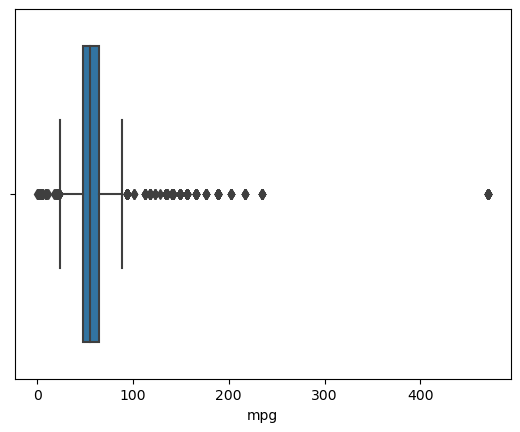

In [206]:
box1 = sns.boxplot(x = 'mpg', data = all_data)

In [207]:
all_data = all_data[all_data['mpg'] < 400]

In [210]:
X = all_data.drop('price', axis = 1)
X = (X - X.mean()) / X.std()
y = all_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [211]:
from catboost import CatBoostRegressor
catModel = CatBoostRegressor(verbose = 0, random_state = 33)
catModel.fit(X_train, y_train)
y_pred = catModel.predict(X_test)
r2 = r2_score(y_pred, y_test)
r2

0.9515128243546026

После удаления выбросов, качество модели незначительно улучшилось. 

In [213]:
feature_imp = pd.Series(catModel.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

engineSize      36.831642
year            22.429358
model           16.870781
mpg             10.306274
mileage          6.428947
transmission     5.050411
fuelType         1.470861
tax              0.611726
dtype: float64

In [239]:
X = all_data.drop('price', axis = 1)
X = X.drop('tax', axis = 1)
X = (X - X.mean()) / X.std()
y = all_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [240]:
catModel = CatBoostRegressor(verbose = 0, random_state = 33)
catModel.fit(X_train, y_train)
y_pred = catModel.predict(X_test)
r2 = r2_score(y_pred, y_test)
r2

0.9558260874585971

In [241]:
parameters = {'max_depth' : [2, 5, 10],
              'learning_rate' : [0.001, 0.01, 0.1, 0.15, 0.3],
              'n_estimators' : range(100, 1000, 30),
              'min_child_samples' : [2, 5, 10]
             }
Rgrid_search = RandomizedSearchCV(catModel, parameters, scoring = 'r2', verbose = False, n_jobs = -1)

Rgrid_search.fit(X_train, y_train)


RandomizedSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x000001E7D28D2740>,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1,
                                                          0.15, 0.3],
                                        'max_depth': [2, 5, 10],
                                        'min_child_samples': [2, 5, 10],
                                        'n_estimators': range(100, 1000, 30)},
                   scoring='r2', verbose=False)

In [242]:
Rgrid_search.best_params_

{'n_estimators': 760,
 'min_child_samples': 10,
 'max_depth': 10,
 'learning_rate': 0.3}

In [243]:
catModel = CatBoostRegressor(verbose = 0, random_state = 33, n_estimators=970, min_child_samples = 5, max_depth=10, learning_rate=0.3)
catModel.fit(X_train, y_train)
y_pred = catModel.predict(X_test)
r2 = r2_score(y_pred, y_test)
r2

0.9648068770650194

In [253]:
pricePredicted = pd.DataFrame({'Actual Price': y_test, 'Predicted Price': y_pred})
pricePredicted['diff'] = round(((pricePredicted['Predicted Price'] - pricePredicted['Actual Price']) / pricePredicted['Actual Price'])*100, 0)
pricePredicted

,Actual Price,Predicted Price,diff
1155,17991,18016.628410,0.0
6695,14750,15466.372090,5.0
5636,14450,13610.420605,-6.0
24518,8691,9047.956765,4.0
6429,13995,17014.735134,22.0
...,...,...,...
53073,24799,24800.160723,0.0
14234,10995,11046.686153,0.0
10144,43950,47828.524162,9.0
54711,21291,23990.261938,13.0


После удаления выбросов, удаления малозначимых признаков (tax), а также подбора гиперпараметров, модель CatBoostRegressor показала результат r2 96,5%, что является очень высоким показателем производительности модели, и наилучшим результатом в нашем исследовании. Разница между выборками в наборе данных и прогнозами, сделанными моделью, минимальна. Модель обладает высокой точностью прогноза цены.